In [3]:
import torch
from time import time 



# 先导入必要的包

In [14]:
a = torch.ones(1000)
b=  torch.ones(1000)
start = time()
c = torch.zeros(1000)
for i in range(1000):
    c[i] = a[i] + 10*b[i]
print(time()-start)
c.view(-1,50)

start1 = time()
d = a + b
print(time() - start1)

0.03789639472961426
0.0


In [12]:
d = c.reshape(-1,50)
d.shape

torch.Size([20, 50])

In [17]:
start1 = time()
d = a + b
print(start1)

1632240722.068122


# 3.2线性回归的从零开始实现

In [2]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random
print(torch.__version__)

1.4.0


## 构造人工样本

In [28]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.from_numpy(np.random.normal(0, 1, (num_examples,num_inputs)))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.from_numpy(np.random.normal(0, 0.01,size=labels.size()))

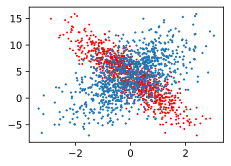

In [36]:
# 生成散点图

def use_svg_diaplay():
    display.set_matplotlib_formats('svg')   # 用矢量图显示
def set_figsize(figsize=(3.5,2.5)):
    use_svg_diaplay()
    #设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize
    
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1,color='red');


D:\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


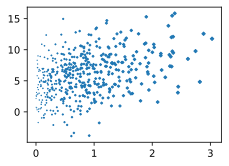

In [41]:
plt.scatter(features[:, 0].numpy(), labels.numpy(), 2*features[:, 0].numpy(),marker = "D");

## 读取数据

In [42]:
# 本函数已保存在d2lzh包中⽅便以后使⽤
def data_iter(batch_size, features, labels):
     num_examples = len(features)
     indices = list(range(num_examples))
     random.shuffle(indices) # 样本的读取顺序是随机的
     for i in range(0, num_examples, batch_size):
         j = torch.LongTensor(indices[i: min(i + batch_size,num_examples)]) # 最后⼀次可能不⾜⼀个batch
         yield features.index_select(0, j), labels.index_select(0, j)

In [43]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
     print(X, y)
     break

tensor([[-0.8137, -1.5793],
        [-0.9261,  0.0837],
        [-0.0517, -1.4175],
        [-1.0633,  0.7878],
        [-0.7761,  0.2580],
        [-0.0090,  0.5616],
        [-0.3183, -2.2527],
        [-0.1149, -1.9800],
        [-0.7336,  0.6920],
        [ 1.9426,  1.3493]], dtype=torch.float64) tensor([ 7.9335,  2.0477,  8.8802, -0.6059,  1.7664,  2.2618, 11.2088, 10.7014,
         0.3844,  3.5194], dtype=torch.float64)


## 初始化模型参数


In [59]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
# 需要更新梯度来迭代
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

## 定义模型和损失函数和优化算法

In [60]:
def linreg(X,w,b):
    return torch.mm(X,w)+b   # torch.mm 为矩阵相乘


def squared_loss(y_hat,y):
    return(y_hat-y.view(y_hat.size())) **2/2

def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

## 训练模型

In [61]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'mat2' in call to _th_mm

In [55]:
w


tensor([[ 0.0084],
        [-0.0112]])

In [56]:
b

tensor([0.])

## 3.3 线性回归的简单实现

In [3]:
import torch
from torch import nn
import numpy as np
torch.manual_seed(1)

print(torch.__version__)
torch.set_default_tensor_type('torch.FloatTensor')

1.4.0


D:\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


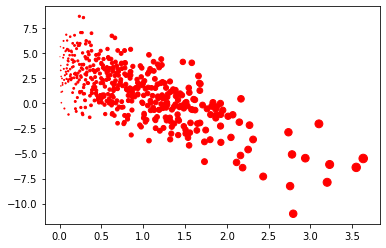

In [10]:
# 生成数据集
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

plt.scatter(features[:, 1].numpy(), labels.numpy(), 20*features[:,1].numpy(),color='red');

In [16]:
## 3.3.2 读取数据
import torch.utils.data as Data

batch_size = 10
# 将训练数据的特征和标签组合  
dataset = Data.TensorDataset(features,labels) 
data_iter = Data.DataLoader(dataset,batch_size,shuffle=True)


In [ ]:
def data_iterr(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [17]:
for X,y in data_iter:
    print(X,y)
    break

tensor([[-0.1055, -0.8474],
        [ 1.0555,  1.8345],
        [-0.0325, -1.8249],
        [-1.3045,  0.1546],
        [-0.0663,  0.5198],
        [ 0.1123,  0.2606],
        [ 0.0929, -0.0684],
        [-2.9098, -1.6291],
        [ 2.9328, -0.8311],
        [-0.2906,  0.4385]]) tensor([ 6.8817,  0.0833, 10.3248,  1.0685,  2.3056,  3.5335,  4.6224,  3.9235,
        12.8736,  2.1260])


In [20]:
# 定义模型
class LinearNet(nn.Module):
    def __init__(self,n_feature):
        super(LinearNet,self).__init__()
        self.linear = nn.Linear(n_feature,1)
        
        #forward 定义前向传播 
    def forward(self,x):
        y = self.linear(x)
        return y
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=False)
)


In [21]:
# 写法⼀
net = nn.Sequential(
     nn.Linear(num_inputs, 1)
     # 此处还可以传⼊其他层
     )

# 写法⼆
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......
# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
     ('linear', nn.Linear(num_inputs, 1))
     # ......
     ]))
print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [22]:
for param in net.parameters():
 print(param)

Parameter containing:
tensor([[-0.6499, -0.1581]], requires_grad=True)
Parameter containing:
tensor([-0.3323], requires_grad=True)


In [23]:
# 初始化模型参数
from torch.nn import init

init.normal_(net[0].weight,mean = 0,std = 0.01)  
init.constant_(net[0].bias,val=0)
# 也可以直接修改bias的data:
# net[0].bias.data.fill_(0)

Parameter containing:
tensor([0.], requires_grad=True)

In [25]:
# 定义损失函数

loss = nn.MSELoss()
# 定义优化算法
import torch.optim as optim
optimizer = optim.SGD(net.parameters(),lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [27]:
#  训练模型
# 在使⽤Gluon训练模型时，我们通过调⽤ optim 实例的 step 函数来迭代模型参数
# 按照⼩批量随机梯度下降的定义，我们在 step 函数中指明批量⼤⼩
# 从⽽对批量中样本梯度求平均。
num_epochs = 3 
for epoch in range(1,num_epochs+1):
    for X,y in data_iter:
        output = net(X)
        l = loss(output,y.view(-1,1))
        optimizer.zero_grad()  #梯度清零 等价于 net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d,loss:%f'%(epoch,l.item()))

epoch 1,loss:0.000190
epoch 2,loss:0.000076
epoch 3,loss:0.000110


In [28]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 2.0011, -3.3989]], requires_grad=True)
4.2 Parameter containing:
tensor([4.2004], requires_grad=True)


## 3.5.1获取数据集

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys
sys.path.append("..") # 为了导⼊上层⽬录的d2lzh_pytorch
import d2lzh_pytorch as d2l

In [4]:
mnist_train = torchvision.datasets.FashionMNIST(root='../Datasets/FashionMNIST',
    train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='../Datasets/FashionMNIST',
    train=False, download=True, transform=transforms.ToTensor())

100.0%


Extracting ../Datasets/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../Datasets/FashionMNIST\FashionMNIST\raw



100.6%


Extracting ../Datasets/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../Datasets/FashionMNIST\FashionMNIST\raw



100.0%


Extracting ../Datasets/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../Datasets/FashionMNIST\FashionMNIST\raw



119.3%


Extracting ../Datasets/FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../Datasets/FashionMNIST\FashionMNIST\raw



D:\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [40]:
def load_data_fashion_mnist(batch_size, resize=None, root='../Datasets/FashionMNIST'):
    """Download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)
    if sys.platform.startswith('win'):
        num_workers = 0  # 0表示不用额外的进程来加速读取数据
    else:
        num_workers = 4
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_iter, test_iter

import torch
import torchvision
import numpy as np
import sys
sys.path.append("..") # 为了导⼊上层⽬录的d2lzh_pytorch
import d2lzh_pytorch as d2l

# 图像28*28拉成一维
num_inputs = 784
num_outputs = 10


W = torch.tensor(np.random.normal(0, 0.01, (num_inputs,
    num_outputs)), dtype=torch.float) 
b = torch.zeros(num_outputs, dtype=torch.float)
# 赋予梯度
W.requires_grad_(requires_grad=True) 
b.requires_grad_(requires_grad=True) 

batch_size = 256
# train_iter, test_iter = load_data_fashion_mnist(batch_size)

### 3.6.3 实现softmax运算

In [33]:
def softmax(X):
     X_exp = X.exp()   # 求指数
     partition = X_exp.sum(dim=1, keepdim=True)  #对每列的指数求和
     return X_exp / partition # 这⾥应⽤了⼴播机制
# 定义网络    
def net(X):
     return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)
    #这⾥通过 view 函数将每张原始图像改成⻓度为 num_inputs 的向量。
# 定义损失函数
def cross_entropy(y_hat, y):
     return - torch.log(y_hat.gather(1, y.view(-1, 1)))
    
#计算分类准确率
def accuracy(y_hat, y):
     return (y_hat.argmax(dim=1) == y).float().mean().item()
# 计算分类精度
def evaluate_accuracy(data_iter, net):
     acc_sum, n = 0.0, 0
     for X, y in data_iter:
         acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
         n += y.shape[0]
     return acc_sum / n

### 3.6.7 训练模型

In [34]:
num_epochs , lr = 5,0.1

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到
            
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [29]:
print(evaluate_accuracy(test_iter, net))

0.1267


# softmax的简介实现

In [36]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

In [41]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
num_inputs = 784
num_outputs = 10

class LinearNet(nn.Module):
    def __init__(self,num_inputs,num_outputs):
        super(LinearNet,self).__init__()
        self.linear = nn.Linear(num_inputs,num_outputs)
    def forward(self,x):  # x shape （batch_size,1,28,28)
        y = self.linear(x.view(x.shape[0],-1))
        #先⽤ view() 将 x 的形状转换成(batch_size, 784)才送⼊全连接层。
        return y
net = LinearNet(num_inputs,num_outputs)

In [42]:
# 我们将对 x 的形状转换的这个功能⾃定义⼀个 FlattenLayer 
# 并记录在 d2lzh_pytorch 中⽅便后⾯使⽤
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer,self).__init__()
    def forward(self,x):
        return x.view(x.shape[0],-1)

In [43]:
from collections import OrderedDict
net = nn.Sequential(
        # FlattenLayer  nn.Linear
        OrderedDict([
            ('flatten',FlattenLayer()),
            ('linear',nn.Linear(num_inputs,num_outputs))
        ])
)

In [44]:
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0) 

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [46]:
# 定义交叉熵损失函数
loss =nn.CrossEntropyLoss()
# 优化算法
optimizer = torch.optim.SGD(net.parameters(),lr=0.1)
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                print("第%d个epoch没有优化器，现在为其添加sgd" %(epoch+1))
                d2l.sgd(params, lr, batch_size)
            else:
                print("第%d个epoch有优化器，直接计算step,更新所有参数" %(epoch+1))
                optimizer.step()  # “softmax回归的简洁实现”一节将用到
            
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]   # 样本数
            print("batch_size 是否等于n：%d"%(batch_size == n))
            print("y.shape[0]为：%d"%(n))
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

In [47]:
num_epochs = 5
train_ch3(net, train_iter, test_iter, loss, num_epochs,
batch_size, None, None, optimizer)

第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：1
y.shape[0]为：256
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：512
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：768
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：1024
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：1280
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：1536
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：1792
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：2048
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：2304
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：2560
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：2816
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：3072
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：3328
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：3584
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：3840
第1个epoch有优化器，直接计算step,更新所有参数

batch_size 是否等于n：0
y.shape[0]为：33024
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：33280
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：33536
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：33792
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：34048
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：34304
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：34560
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：34816
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：35072
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：35328
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：35584
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：35840
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：36096
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：36352
第1个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：36608
第1个epoch有优化器，直接计算step,更新所有参数
batch_size

batch_size 是否等于n：0
y.shape[0]为：5120
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：5376
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：5632
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：5888
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：6144
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：6400
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：6656
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：6912
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：7168
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：7424
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：7680
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：7936
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：8192
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：8448
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：8704
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shap

第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：37376
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：37632
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：37888
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：38144
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：38400
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：38656
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：38912
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：39168
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：39424
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：39680
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：39936
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：40192
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：40448
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：40704
第2个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：40960
第2个epoch有优

batch_size 是否等于n：0
y.shape[0]为：8960
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：9216
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：9472
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：9728
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：9984
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：10240
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：10496
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：10752
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：11008
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：11264
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：11520
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：11776
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：12032
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：12288
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：12544
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于

batch_size 是否等于n：0
y.shape[0]为：41472
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：41728
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：41984
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：42240
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：42496
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：42752
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：43008
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：43264
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：43520
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：43776
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：44032
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：44288
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：44544
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：44800
第3个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：45056
第3个epoch有优化器，直接计算step,更新所有参数
batch_size

batch_size 是否等于n：0
y.shape[0]为：14080
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：14336
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：14592
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：14848
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：15104
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：15360
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：15616
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：15872
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：16128
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：16384
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：16640
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：16896
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：17152
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：17408
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：17664
第4个epoch有优化器，直接计算step,更新所有参数
batch_size

batch_size 是否等于n：0
y.shape[0]为：47104
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：47360
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：47616
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：47872
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：48128
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：48384
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：48640
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：48896
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：49152
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：49408
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：49664
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：49920
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：50176
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：50432
第4个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：50688
第4个epoch有优化器，直接计算step,更新所有参数
batch_size

batch_size 是否等于n：0
y.shape[0]为：19200
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：19456
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：19712
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：19968
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：20224
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：20480
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：20736
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：20992
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：21248
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：21504
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：21760
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：22016
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：22272
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：22528
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：22784
第5个epoch有优化器，直接计算step,更新所有参数
batch_size

batch_size 是否等于n：0
y.shape[0]为：51968
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：52224
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：52480
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：52736
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：52992
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：53248
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：53504
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：53760
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：54016
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：54272
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：54528
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：54784
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：55040
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：55296
第5个epoch有优化器，直接计算step,更新所有参数
batch_size 是否等于n：0
y.shape[0]为：55552
第5个epoch有优化器，直接计算step,更新所有参数
batch_size

# 3.8 多层感知机

#### 3.8.2.1 ReLU函数

In [48]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pylab as plt
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

In [49]:
def xyplot(x_vals,y_vals,name):
    d2l.set_figsize(figsize=(5,2.5))
    d2l.plt.plot(x_vals.detach().numpy(),y_vals.detach().numpy())  #简单来说detach就是截断反向传播的梯度流。
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name+'(x)')

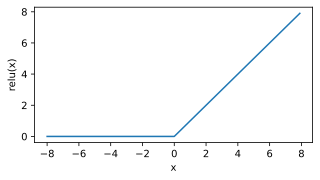

In [50]:
x = torch.arange(-8.0,8.0,0.1,requires_grad=True)
y=x.relu()
xyplot(x,y,'relu')

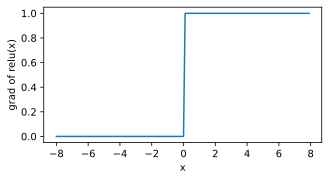

In [51]:
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

#### sigmoid函数


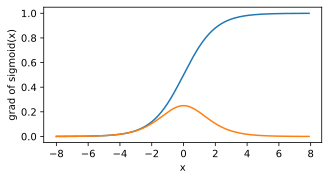

In [54]:
y=x.sigmoid()
xyplot(x,y,'sigmoid')
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')

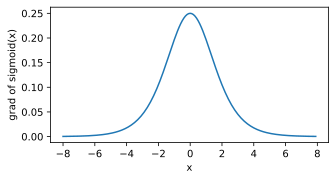

In [53]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')

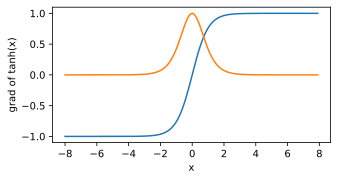

In [56]:
y = x.tanh()
xyplot(x, y, 'tanh')
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of tanh')

# 3.9 多层感知机的实现

In [57]:
import torch
import numpy as np
import sys
# sys.path.append("..")
import d2lzh_pytorch as d2l

In [70]:
# 获取数据
batch_size = 256
train_iter,test_iter = load_data_fashion_mnist(batch_size)
# 定义模型参数
num_inputs,num_outputs,num_hiddens = 784,10,256

W1 = torch.tensor(np.random.normal(0,0.01,(num_inputs,num_hiddens)),dtype=torch.float)
b1=torch.zeros(num_hiddens,dtype=torch.float)
W2 = torch.tensor(np.random.normal(0,0.01,(num_hiddens,num_outputs)),dtype = torch.float)
b2 = torch.zeros(num_outputs,dtype=torch.float)

params = [W1,b1,W2,b2]
for param in params:
    param.requires_grad_(requires_grad = True)
    
#定义激活函数
def relu(X):
    return torch.max(input=X,other = torch.tensor(0.0))  # max函数输入的other为比较的tensor
# 这里是和0比较，大于零的等于x，小于的等于0

# 定义模型

def net(X):
    X= X.view((-1,num_inputs))
    H = relu(torch.matmul(X,W1)+ b1)
    return torch.matmul(H,W2) + b2
loss = torch.nn.CrossEntropyLoss()

注：由于原书的mxnet中的 SoftmaxCrossEntropyLoss 在反向传播的时候相对于沿batch维求
和了，⽽PyTorch默认的是求平均，所以⽤PyTorch计算得到的loss⽐mxnet⼩很多（⼤概是
maxnet计算得到的1/batch_size这个量级），所以反向传播得到的梯度也⼩很多，所以为了得到
差不多的学习效果，我们把学习率调得成原书的约batch_size倍，原书的学习率为0.5，这⾥设置
成100.0。(之所以这么⼤，应该是因为d2lzh_pytorch⾥⾯的sgd函数在更新的时候除以了
batch_size，其实PyTorch在计算loss的时候已经除过⼀次了，sgd这⾥应该不⽤除了)



In [71]:
num_epochs , lr = 5,100
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,batch_size, params, lr)

epoch 1, loss 0.0030, train acc 0.717, test acc 0.772
epoch 2, loss 0.0019, train acc 0.824, test acc 0.813
epoch 3, loss 0.0017, train acc 0.846, test acc 0.835
epoch 4, loss 0.0015, train acc 0.856, test acc 0.804
epoch 5, loss 0.0015, train acc 0.864, test acc 0.830


In [72]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,batch_size, params, 0.5)

epoch 1, loss 0.0014, train acc 0.870, test acc 0.865
epoch 2, loss 0.0013, train acc 0.882, test acc 0.864
epoch 3, loss 0.0013, train acc 0.883, test acc 0.864
epoch 4, loss 0.0013, train acc 0.883, test acc 0.864
epoch 5, loss 0.0013, train acc 0.883, test acc 0.864


# 多层感知机的简洁实现

In [73]:
import torch
from torch import nn
from torch.nn import init
import numpy as np

import d2lzh_pytorch as d2l

In [77]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

net = nn.Sequential(
    d2l.FlattenLayer(),
    nn.Linear(num_inputs,num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens,num_outputs))

for params in net.parameters():
    init.normal_(params,mean = 0,std = 0)

In [79]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
batch_size, None, None, optimizer)

epoch 1, loss 0.0090, train acc 0.099, test acc 0.100
epoch 2, loss 0.0090, train acc 0.100, test acc 0.100
epoch 3, loss 0.0090, train acc 0.098, test acc 0.100
epoch 4, loss 0.0090, train acc 0.100, test acc 0.100
epoch 5, loss 0.0090, train acc 0.098, test acc 0.100
